In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib,lightfm

Ethen 2018-04-11 15:20:41 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
matplotlib 2.2.2
lightfm 1.14


/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# WARP (Weighted Approximate Rank Pairwise Loss)

# Implementation

In [2]:
import pandas as pd
# download the data if it's not in the same local directory
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])


user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
timestamp_col = 'timestamp'

names = [user_col, item_col, rating_col, timestamp_col]
df = pd.read_csv(file_path, sep = '\t', names = names)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The next thing is to conduct a train/test split so we can have the main dataset that we'll use to train our model and a holdout dataset that is used to evaluate the model. Here we'll utilize the `timestamp` column to perform this operation, where we use data before 1998/04 as training and any data after that time is treated as testing data.

In [3]:
df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit = 's')
mask = df[timestamp_col] > pd.Timestamp('1998-04')
df_train = df[~mask]
df_test = df[mask]

print('training set dimension: ', df_train.shape)
print('testing set dimension: ', df_test.shape)

training set dimension:  (90641, 4)
testing set dimension:  (9359, 4)


In [4]:
from epsilon.transformers import SparseMatrixTransformer


# https://github.com/pandas-dev/pandas/issues/18646
sparse_tr = SparseMatrixTransformer(user_col, item_col, rating_col)
X_train = sparse_tr.fit_transform(df_train)
X_test = sparse_tr.transform(df_test)
X_train

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


<868x1639 sparse matrix of type '<class 'numpy.float32'>'
	with 90640 stored elements in Compressed Sparse Row format>

In [6]:
SIGMOID_TABLE_SIZE = 512
MAX_SIGMOID = 8

t_sigmoid = np.zeros(SIGMOID_TABLE_SIZE)

for i in range(SIGMOID_TABLE_SIZE):
    x = (i / SIGMOID_TABLE_SIZE * 2 - 1) * MAX_SIGMOID
    t_sigmoid[i] = 1 / (np.exp(-x)+1.)


def sigmoid(x):
    if x >= MAX_SIGMOID:
        return 1.
    elif x <= -MAX_SIGMOID:
        return 0.
    else:
        return t_sigmoid[(int)((x + MAX_SIGMOID) * (SIGMOID_TABLE_SIZE / MAX_SIGMOID / 2))]

sigmoid(x=0.)  # 0.5
sigmoid(x=0.7) # 0.66541055874681398
sigmoid(x=10.) 

1.0

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


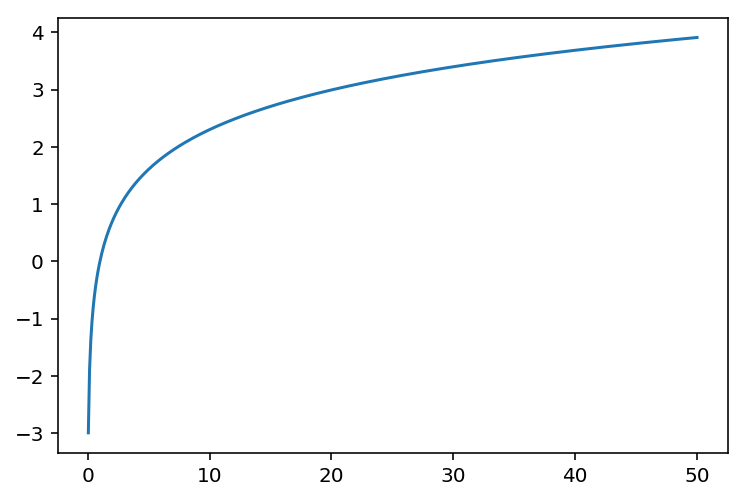

In [20]:
# log table 0 ~ 50
x = np.linspace(-50, 50, num = 1000)
y = np.log(x)
plt.plot(x, y)

In [32]:
np.exp(5)

148.4131591025766

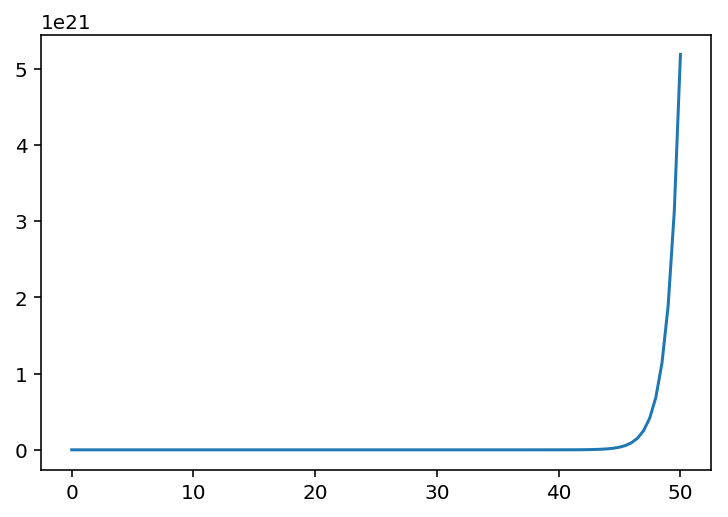

In [30]:
x = np.linspace(0, 50, num = 100)
y = np.exp(x)
plt.plot(x, y)

In [18]:
500 / SIGMOID_TABLE_SIZE * 2 - 1

0.953125

In [12]:
%%timeit
1 / (1 + np.exp(-0))
1 / (1 + np.exp(-0.7))
1 / (1 + np.exp(-10))

3.91 µs ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%%timeit
sigmoid(x=0.)  # 0.5
sigmoid(x=0.7) # 0.66541055874681398
sigmoid(x=10.)

1.13 µs ± 5.58 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
from joblib import cpu_count

reg = 0.1
n_iters = 30
n_factors = 50
n_jobs = cpu_count()
learning_rate = 0.01

parameters = {
    'reg': reg,
    'n_jobs': n_jobs,
    'n_iters': n_iters,
    'n_factors': n_factors,
    'learning_rate': learning_rate}

In [ ]:
from lightfm import LightFM


start = time()
lightfm = LightFM(learning_rate = learning_rate, loss = 'warp',
                  item_alpha = reg, user_alpha = reg,
                  no_components = n_factors, learning_schedule = 'adagrad')
lightfm.fit(X_train, epochs = n_iters, num_threads = n_jobs)
warp_lightfm_time = time() - start
print(time() - start)

In [ ]:
k = 5
train_precision = precision_at_k(lightfm, X_train, k = k).mean()
test_precision = precision_at_k(lightfm, X_test, k = k).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))